Relax and Hold Steady part 3

Test problem:

\begin{equation}
  \begin{gathered}
p=0 \text{ at } x=0\\
\frac{\partial p}{\partial x} = 0 \text{ at } x = L\\
p = 0 \text{ at }y = 0 \\
p = \sin \left(  \frac{\frac{3}{2}\pi x}{L} \right) \text{ at } y = H
  \end{gathered}
\end{equation}



In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
from laplace_helper import p_analytical, plot_3D, L2_rel_error

In [3]:
nx = 128
ny = 128

L = 5
H = 5

x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)

dx = L/(nx-1)
dy = H/(ny-1)

p0 = numpy.zeros((ny,nx))

p0[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])

In [4]:
def laplace2d(p,y,dx,dy,target):
    
    norm = 1
    pn = numpy.empty_like(p)
    iterations = 0
    
    while norm > target:
        pn = p.copy()
        
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1,:-2] +\
                              pn[2:,1:-1] + pn[:-2,1:-1])
        
        p[1:-1,-1] = .25 * (2*pn[1:-1,-2] + pn[2:,-1] + pn[:-2, -1])
        
        norm = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
        iterations += 1
     
    return p, iterations
        

In [5]:
eps = 1e-8
p,iterations = laplace2d(p0.copy(), y, dx, dy, eps)

print ("Jacobi method took {} iterations at tolerance {}".\
        format(iterations, eps))

Jacobi method took 19993 iterations at tolerance 1e-08


In [6]:
%%timeit
laplace2d(p0.copy(), y, dx, dy, eps)

1 loops, best of 3: 5.11 s per loop


In [7]:
pan = p_analytical(x,y)

In [8]:
L2_rel_error(p,pan)

6.1735513352884566e-05

Gauss-Seidel

single jacobi iteration is written as:

\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k}_{i,j-1} + p^k_{i,j+1} + p^{k}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}

The iteration for Gauss-Seidell is thus:

\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k+1}_{i,j-1} + p^k_{i,j+1} + p^{k+1}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}



In [9]:
def laplace2d_gauss_deidel(p,y,dx,dy,nx,ny,eps):
    iterations = 0
    error = eps+1
    
    while error > eps:
        pn = p.copy()
        error = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
                error += (p[j,i] - pn[j,i])**2
        
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
        error = numpy.sqrt(error/numpy.sum(pn**2))
        iterations += 1        
        
    return p, iterations
    

We would then run this with the following function call:

```Python
p, iterations = laplace2d_gauss_seidel(p, y, dx, dy, nx, ny, 1e-8)
```

But **don't do it**.  We did it so that you don't have to!  

The solution of our test problem with the Gauss-Seidel method required several thousand fewer iterations than the Jacobi method, but it took more than *7 minutes* to run on our machine.

Use Numba!

Numba is an open source optimizing compiler for python.



In [10]:
import numba
from numba import jit

In [11]:
def fib_it(n):
    a =1
    b = 1
    for i in range(n-2):
        a,b = b, a+b
        
    return b

In [13]:
%%timeit
fib_it(500000)

1 loops, best of 3: 4.62 s per loop


In [14]:
@jit
def fib_it(n):
    a =1
    b = 1
    for i in range(n-2):
        a,b = b, a+b
        
    return b

In [15]:
%%timeit
fib_it(500000)

The slowest run took 3421.31 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 335 µs per loop


In [16]:
%%timeit
fib_it(500000)

1000 loops, best of 3: 202 µs per loop


In [17]:
@jit(nopython=True)

SyntaxError: unexpected EOF while parsing (<ipython-input-17-b2eec42f422f>, line 1)

In [18]:
print(numba.__version__)

0.19.1


In [19]:
@jit(nopython=True)
def laplace2d_jacobi(p, pn, y, dx, dy, eps):
    
    iterations = 0
    error = eps+1 #initialize error to be larger than eps
    ny, nx = p.shape
    l2err = numpy.zeros(20000)
    
    while error > eps:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
        error = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (pn[j,i-1] + pn[j,i+1] + pn[j-1,i] + pn[j+1,i])
                
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*pn[j,-2] + pn[j+1,-1] + pn[j-1, -1])
            
            
        for j in range(ny):
            for i in range(nx):
                error += (p[j,i] - pn[j,i])**2
        
        
        error = numpy.sqrt(error/numpy.sum(pn**2))
        l2err[iterations] = error
        iterations += 1    
        
    return p, iterations, l2err

In [20]:
p, iterations, l2errJ = laplace2d_jacobi(p0.copy(), p0.copy(), y, dx, dy, 1e-8)

print("Numba Jacobi method took {} iterations at tolerance {}".format(iterations, eps))

Numba Jacobi method took 19993 iterations at tolerance 1e-08


In [21]:
%%timeit 
laplace2d_jacobi(p0.copy(), p0.copy(), y, dx, dy, 1e-8)

1 loops, best of 3: 19.8 s per loop


In [22]:
@jit(nopython=True)
def laplace2d_gauss_seidel(p, pn, y, dx, dy, eps):

    iterations = 0
    error = eps + 1 #initialize error to be larger than eps
    ny, nx = p.shape
    l2err = numpy.zeros(20000)
    
    while error > eps:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
        error = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
                
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
            
        for j in range(ny):
            for i in range(nx):
                error += (p[j,i] - pn[j,i])**2
        
        
        error = numpy.sqrt(error/numpy.sum(pn**2))
        l2err[iterations] = error
        iterations += 1    
        
    return p, iterations, l2err

In [23]:
p, iterations, l2errGS = laplace2d_gauss_seidel(p0.copy(), p0.copy(), y, dx, dy, 1e-8)

print("Numba Gauss-Seidel method took {} iterations at tolerance {}".format(iterations, eps))

Numba Gauss-Seidel method took 13939 iterations at tolerance 1e-08


In [24]:
%%timeit
laplace2d_gauss_seidel(p0.copy(), p0.copy(), y, dx, dy, 1e-8)

1 loops, best of 3: 15.2 s per loop


In [25]:
@jit(nopython=True)
def laplace2d_SOR(p, pn, y, dx, dy, eps, omega):
    
    iterations = 0
    error = eps + 1 #initialize error to be larger than eps
    ny, nx = p.shape
    l2err = numpy.zeros(20000)
    
    while error > eps:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
        error = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = (1-omega)*p[j,i] + omega*.25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
        for j in range(ny):
            for i in range(nx):
                error += (p[j,i] - pn[j,i])**2
            
        error = numpy.sqrt(error/numpy.sum(pn**2))
        l2err[iterations] = error
        iterations += 1        
        
    
    return p, iterations, l2err

In [26]:
eps = 1e-8
omega = 1
p, iterations, l2errSOR = laplace2d_SOR(p0.copy(), p0.copy(), y, dx, dy, eps, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {}".format(iterations, eps, omega))

Numba SOR method took 13939 iterations at tolerance 1e-08 with omega = 1


In [27]:
eps = 1e-8
omega = 1.5
p, iterations, l2errSOR = laplace2d_SOR(p0.copy(), p0.copy(), y, dx, dy, eps, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {}".format(iterations, eps, omega))

Numba SOR method took 7108 iterations at tolerance 1e-08 with omega = 1.5


In [28]:
%%timeit
laplace2d_SOR(p0.copy(), p0.copy(), y, dx, dy, eps, omega)

1 loops, best of 3: 7.23 s per loop


In [29]:
eps = 1e-8
omega = 2./(1 + numpy.pi/nx)
p, iterations, l2errSORopt = laplace2d_SOR(p0.copy(), p0.copy(), y, dx, dy, eps, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {:.4f}".format(iterations, eps, omega))

Numba SOR method took 1110 iterations at tolerance 1e-08 with omega = 1.9521


In [30]:
%%timeit
laplace2d_SOR(p0.copy(), p0.copy(), y, dx, dy, eps, omega)

1 loops, best of 3: 1.1 s per loop


In [31]:
L2_rel_error(p,pan)

7.7927433550683514e-05

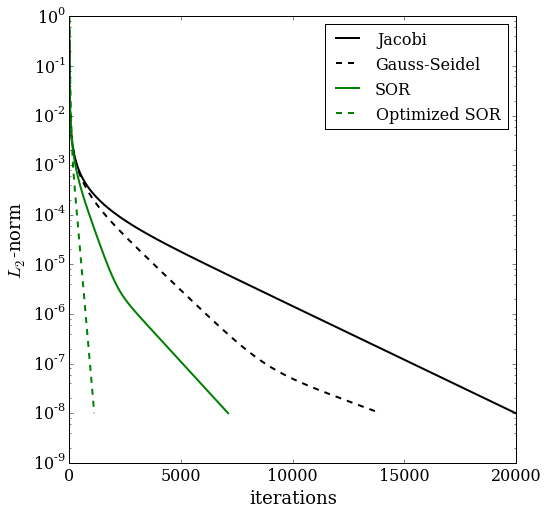

In [32]:
pyplot.figure(figsize=(8,8))
pyplot.xlabel(r'iterations', fontsize=18)
pyplot.ylabel(r'$L_2$-norm', fontsize=18)
pyplot.semilogy(numpy.trim_zeros(l2errJ,'b'),
                'k-', lw=2, label='Jacobi')
pyplot.semilogy(numpy.trim_zeros(l2errGS,'b'), 
                'k--', lw=2, label='Gauss-Seidel')
pyplot.semilogy(numpy.trim_zeros(l2errSOR,'b'), 
                'g-', lw=2, label='SOR')
pyplot.semilogy(numpy.trim_zeros(l2errSORopt,'b'), 
                'g--', lw=2, label='Optimized SOR')
pyplot.legend(fontsize=16);